<a href="https://colab.research.google.com/github/satvikmoj/DeepSync/blob/main/Stacked_DeepSync_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import time
import torch
import pathlib
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import IPython
import tqdm

from ipywidgets import IntProgress

import PIL
from PIL import Image
import os
import numpy as np



try: 
    import pretrainedmodels as pm
except:
    !git clone https://github.com/Cadene/pretrained-models.pytorch.git
    

Cloning into 'pretrained-models.pytorch'...
remote: Enumerating objects: 803, done.
remote: Total 803 (delta 0), reused 0 (delta 0), pack-reused 803
Receiving objects: 100% (803/803), 522.66 KiB | 3.99 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [ ]:
%cd pretrained-models.pytorch
!git pull origin master
!pip install -r requirements.txt
!python setup.py install
import pretrainedmodels as pm

/content/pretrained-models.pytorch
From https://github.com/Cadene/pretrained-models.pytorch
 * branch            master     -> FETCH_HEAD
Already up to date.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating pretrainedmodels.egg-info
writing pretrainedmodels.egg-info/PKG-INFO
writing dependency_links to pretrainedmodels.egg-info/dependency_links.txt
writing requirements to pretrainedmodels.egg-info/requires.txt
writing top-level names to pretrainedmodels.egg-info/top_level.txt
writing manifest file 'pretrainedmodels.egg-info/SOURCES.txt'
adding license file 'LICENSE.txt'
writing manifest file 'pretrainedmodels.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating bu

Install Dependencies/Set Seed and Such


In [ ]:
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


Overfitting Inception Res Net V2 on EEG PSDED graphs


Load Data:


In [ ]:
def load_data(directory, test=False):

    dataDict = {'entries':[] , 'labels':[]}

    noSZcounter = 0
    noSZchannels = []


    SZcounter = 0
    SZchannels = []
    if test:
      for name in sorted(os.listdir(directory)):
        print(name)
        if name.endswith('.jpeg'):
            imageName = directory + name
            imageData = Image.open(imageName)

        
    # put data and target into seizure class or no_seizure class
        if name.endswith("0r.jpeg"): 
            
            noSZchannels.append(imageData)
            noSZcounter += 1
            if noSZcounter == 16:
                print('IM APPENDING LIST (noSZ):')
                dataDict['entries'].append(noSZchannels)
                dataDict['labels'].append(0)
                noSZchannels = []
                noSZcounter = 0

        elif name.endswith('1r.jpeg'):
            SZchannels.append(imageData)
            SZcounter += 1
            if SZcounter == 16:
                print('IM APPENDING LIST (SZ):')
                dataDict['entries'].append(SZchannels)
                dataDict['labels'].append(1)
                SZchannels = []
                SZcounter = 0
    else:
      for name in sorted(os.listdir(directory)):
          print(name)
          if name.endswith('.jpeg'):
              imageName = directory + name
              imageData = Image.open(imageName)

          
      # put data and target into seizure class or no_seizure class
      
          if name.endswith("0.jpeg"): 
              
              noSZchannels.append(imageData)
              noSZcounter += 1
              if noSZcounter == 16:
                  print('IM APPENDING LIST (noSZ):')
                  dataDict['entries'].append(noSZchannels)
                  dataDict['labels'].append(0)
                  noSZchannels = []
                  noSZcounter = 0

          elif name.endswith('1.jpeg'):
              SZchannels.append(imageData)
              SZcounter += 1
              if SZcounter == 16:
                  print('IM APPENDING LIST (SZ):')
                  dataDict['entries'].append(SZchannels)
                  dataDict['labels'].append(1)
                  SZchannels = []
                  SZcounter = 0
            
                
    return dataDict

In [ ]:
# def load_data(directory):

#     dataDict = {'entries':[] , 'labels':[]}

#     # noSZcounter = 0
#     # noSZchannels = []


#     # SZcounter = 0
#     # SZchannels = []

#     for name in sorted(os.listdir(directory)):
#         print(name)
#         if name.endswith('.jpeg'):
#             imageName = directory + name
#             imageData = Image.open(imageName)

        
#     # put data and target into seizure class or no_seizure class
#         if name.endswith("0.jpeg"): 
            
#             # noSZchannels.append(imageData)
#             # noSZcounter += 1
#             # if noSZcounter == 16:
#               print('IM APPENDING LIST (noSZ):')
#               dataDict['entries'].append(imageData)
#               dataDict['labels'].append(0)
#               # noSZchannels = []
#               # noSZcounter = 0

#         elif name.endswith('1.jpeg'):
#             # SZchannels.append(imageData)
#             # SZcounter += 1
#             # if SZcounter == 16:
#               print('IM APPENDING LIST (SZ):')
#               dataDict['entries'].append(imageData)
#               dataDict['labels'].append(1)
#               # SZchannels = []
#               # SZcounter = 0
                
    # return dataDict

In [ ]:
test = True
dataDict = load_data('/content/drive/My Drive/Jpegs_Pat1Train/')
testDict = load_data("/content/drive/My Drive/testing/", test=test)

Pat1Ttrain_100_0_0.jpeg
Pat1Ttrain_100_10_0.jpeg
Pat1Ttrain_100_11_0.jpeg
Pat1Ttrain_100_12_0.jpeg
Pat1Ttrain_100_13_0.jpeg
Pat1Ttrain_100_14_0.jpeg
Pat1Ttrain_100_15_0.jpeg
Pat1Ttrain_100_1_0.jpeg
Pat1Ttrain_100_2_0.jpeg
Pat1Ttrain_100_3_0.jpeg
Pat1Ttrain_100_4_0.jpeg
Pat1Ttrain_100_5_0.jpeg
Pat1Ttrain_100_6_0.jpeg
Pat1Ttrain_100_7_0.jpeg
Pat1Ttrain_100_8_0.jpeg
Pat1Ttrain_100_9_0.jpeg
IM APPENDING LIST (noSZ):
Pat1Ttrain_102_0_0.jpeg
Pat1Ttrain_102_10_0.jpeg
Pat1Ttrain_102_11_0.jpeg
Pat1Ttrain_102_12_0.jpeg
Pat1Ttrain_102_13_0.jpeg
Pat1Ttrain_102_14_0.jpeg
Pat1Ttrain_102_15_0.jpeg
Pat1Ttrain_102_1_0.jpeg
Pat1Ttrain_102_2_0.jpeg
Pat1Ttrain_102_3_0.jpeg
Pat1Ttrain_102_4_0.jpeg
Pat1Ttrain_102_5_0.jpeg
Pat1Ttrain_102_6_0.jpeg
Pat1Ttrain_102_7_0.jpeg
Pat1Ttrain_102_8_0.jpeg
Pat1Ttrain_102_9_0.jpeg
IM APPENDING LIST (noSZ):
Pat1Ttrain_107_0_0.jpeg
Pat1Ttrain_107_10_0.jpeg
Pat1Ttrain_107_11_0.jpeg
Pat1Ttrain_107_12_0.jpeg
Pat1Ttrain_107_13_0.jpeg
Pat1Ttrain_107_14_0.jpeg
Pat1Ttrain_107_15_0

In [ ]:
print("shape of siezure data --> " + str(len(dataDict['entries'])) + " with " + str(len(dataDict['labels'])) + " Targets", "\n")
print("shape of test data --> " + str(len(testDict['entries'])) + " with " + str(len(testDict['labels'])) + " Targets", "\n")

shape of siezure data --> 156 with 156 Targets 

shape of test data --> 50 with 50 Targets 



In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms

class psdedDataset(Dataset):
    def __init__(self, dataDict, transform=None, target_transform=None):
        self.img_labels = dataDict['labels']
        self.transform = transform
        self.target_transform = target_transform
        print('Done!')

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        images = dataDict['entries'][idx]
        label = self.img_labels[idx]
        if self.transform:
            imagesT = []
            for image in images:
                imagesT.append(self.transform(image))
        
            images = torch.cat(imagesT, dim=0)
                
        if self.target_transform:
            label = self.target_transform(label)
        return images, label
    
data_transforms = transforms.Compose((transforms.Resize((299, 299)),
                                      transforms.ToTensor()))

psdedDataset = psdedDataset(dataDict, transform=data_transforms)

print(psdedDataset.__getitem__(0)[0].shape)

Done!
torch.Size([48, 299, 299])


In [ ]:
class test_psdedDataset(Dataset):
    def __init__(self, dataDict, transform=None, target_transform=None):
        self.img_labels = dataDict['labels']
        self.transform = transform
        self.target_transform = target_transform
        print('Done!')

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        images = dataDict['entries'][idx]
        label = self.img_labels[idx]
        if self.transform:
            imagesT = []
            for image in images:
                imagesT.append(self.transform(image))
        
            images = torch.cat(imagesT, dim=0)
                
        if self.target_transform:
            label = self.target_transform(label)
        return images, label

test_psdedDataset = test_psdedDataset(testDict, transform = data_transforms)

print(test_psdedDataset.__getitem__(0)[0].shape)

Done!
torch.Size([48, 299, 299])


In [ ]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt
# import pandas as pd
# from torchvision import transforms

# class psdedDataset(Dataset):
#     def __init__(self, dataDict, transform=None, target_transform=None):
#         self.img_labels = dataDict['labels']
#         self.transform = transform
#         self.target_transform = target_transform
#         print('Done!')

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#           image = dataDict['entries'][idx]
#           label = self.img_labels[idx]
#           if self.transform:
#               image = self.transform(image)

#           if self.target_transform:
#               label = self.target_transform(label)
#           return image, label
    
# train_transform = transforms.Compose((transforms.Resize((299, 299)),
#                                       transforms.ToTensor()))
# psdedDataset = psdedDataset(dataDict, transform=train_transform)
# (psdedDataset.__getitem__(0))


Done!


(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]), 0)

In [ ]:
for x in range(psdedDataset.__len__()):
  print(psdedDataset.__getitem__(x)[1])

0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
1
0
1
0
0
0
1
0
1
0
1
0
1
1
0
0
0
0
1
0
1
0
0
0
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
0
1
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
1
0
1
0
0
0


In [ ]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt
# import pandas as pd
# from torchvision import transforms

# class psdedDataset(Dataset):
#     def __init__(self, dataDict, transform=None, target_transform=None):
#         self.img_labels = dataDict['labels']
#         self.transform = transform
#         self.target_transform = target_transform
#         print('Done!')

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         images = (dataDict['entries'][idx])
#         label = self.img_labels[idx]
#         if self.transform:
#             imagesT = []
#             for image in images:
#                 imagesT.append(self.transform(image))
        
#             images = torch.cat(imagesT, dim=0)
                
#         if self.target_transform:
#             label = self.target_transform(label)
#         return images, label
    
# train_transform = transforms.Compose((transforms.Resize((256, 256)),
#                                       transforms.ToTensor()))
# psdedDataset = psdedDataset(dataDict, transform=train_transform)
# (psdedDataset.__getitem__(0)[0]).shape


Done!


torch.Size([48, 256, 256])

Load Data in Batches

dataiter set! <torch.utils.data.dataloader._SingleProcessDataLoaderIter object at 0x7f4111c90a10>
nexted
tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[1., 1

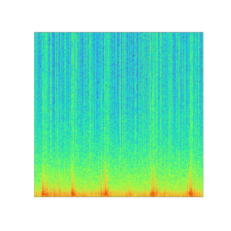

In [ ]:
# import random
# from torchvision.utils import make_grid

# image_count = psdedDataset.__len__()
# train_indices = []
# test_indices = []

# for i in range(image_count):
#   # Put ten percent of the images in the test set
#     if random.random() < .3:
#         test_indices.append(i)
#     else:
#         train_indices.append(i)

# psded_test_set = torch.utils.data.Subset(psdedDataset, test_indices)
# psded_train_set = torch.utils.data.Subset(psdedDataset, train_indices)

# psded_train_loader = torch.utils.data.DataLoader(psded_train_set,
#                                                    batch_size=16,
#                                                    shuffle=True,)
# psded_test_loader = torch.utils.data.DataLoader(psded_test_set,
#                                                   batch_size=16)

# dataiter = iter(psded_train_loader)
# print('dataiter set!', dataiter)
# images, labels = dataiter.next()
# print("nexted")
# print(labels)
# print(images)

# #show images
# #plt.imshow(images[1].permute(1,2,0))
# plt.imshow(images[0,3:6,:].permute(1, 2, 0))
# # plt.imshow(images[0,6:9,:].permute(1, 2, 0))
# plt.axis('off')
# plt.show()


dataiter set! <torch.utils.data.dataloader._SingleProcessDataLoaderIter object at 0x7f3e26f2ffd0>
nexted
tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1])
tensor([[[[0.9961, 0.9922, 0.9961,  ..., 1.0000, 0.9961, 1.0000],
          [1.0000, 1.0000, 0.9922,  ..., 0.9961, 0.9961, 1.0000],
          [0.9961, 1.0000, 0.9529,  ..., 0.9451, 0.9608, 1.0000],
          ...,
          [1.0000, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
          [0.9843, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 0.9922,  ..., 1.0000, 0.9961, 1.0000],
          [0.9961, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 1.0000],
          [1.0000, 0.9961, 0.9608,  ..., 0.9451, 0.9608, 1.0000],
          ...,
          [0.9961, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1

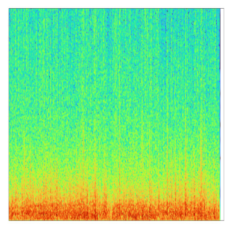

In [ ]:
import random
from torchvision.utils import make_grid

image_count = psdedDataset.__len__()

train_indices = []
val_indices = []
test_indices = []


for i in range(image_count):
  # Put ten percent of the images in the test set
    if random.random() < .1:
        val_indices.append(i)
    else:
        train_indices.append(i)

if test:
  test_count = test_psdedDataset.__len__()
  for i in range(test_count):
    test_indices.append(i)
  psded_test_set = torch.utils.data.Subset(test_psdedDataset, test_indices)
  psded_test_loader = torch.utils.data.DataLoader(psded_test_set, batch_size=16)

psded_train_set = torch.utils.data.Subset(psdedDataset, train_indices)
psded_val_set = torch.utils.data.Subset(psdedDataset, val_indices)


psded_train_loader = torch.utils.data.DataLoader(psded_train_set,
                                                   batch_size=16,
                                                   shuffle=True,)
psded_val_loader = torch.utils.data.DataLoader(psded_val_set,
                                                  batch_size=16)



dataiter = iter(psded_train_loader)
print('dataiter set!', dataiter)
images, labels = dataiter.next()
print("nexted")
print(labels)
print(images)

#show images
#plt.imshow(images[1].permute(1,2,0))
plt.imshow(images[0,3:6,:].permute(1, 2, 0))
# plt.imshow(images[0,6:9,:].permute(1, 2, 0))
plt.axis('off')
plt.show()

Download Model and Set Training/Testing

In [ ]:
class NLL_OHEM(torch.nn.NLLLoss):                                                     
    """ Online hard example mining. 
    Needs input from nn.LogSoftmax() """                                                                                                                            
    def __init__(self, ratio):      
        super(NLL_OHEM, self).__init__(None, True)                                 
        self.ratio = ratio                                                         
                                                                                   
    def forward(self, x, y, ratio=None):                                           
        if ratio is not None:                                                      
            self.ratio = ratio                                                     
        num_inst = x.size(0)                                                       
        num_hns = int(self.ratio * num_inst)                                       
        x_ = x.clone()                                                             
        inst_losses = torch.autograd.Variable(torch.zeros(num_inst)).cuda()              
        for idx, label in enumerate(y.data):                                       
            inst_losses[idx] = -x_.data[idx, label]                                 
        #loss_incs = -x_.sum(1)                                                    
        _, idxs = inst_losses.topk(num_hns)                                        
        x_hn = x.index_select(0, idxs)                                             
        y_hn = y.index_select(0, idxs)                                             
        return th.nn.functional.nll_loss(x_hn, y_hn)  

Download Model

In [ ]:

  
model_name = 'inceptionresnetv2' 
model = pm.__dict__[model_name](num_classes=1000, pretrained='imagenet')
print(model)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to /root/.cache/torch/hub/checkpoints/inceptionresnetv2-520b38e4.pth


  0%|          | 0.00/213M [00:00<?, ?B/s]

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
num_classes = 2
num_ftrs = 1536
# reset final fully connected layer, number of classes = yes seizure or no seizure
#model.conv2d_1a = nn.Sequential(nn.Conv2d(48, 3, kernel_size=(3, 3), stride = 2, bias = False), nn.BatchNorm2d(3, eps=0.001, momentum=0.1, affine=True, track_running_stats=True), nn.ReLU(), nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False), nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True), nn.ReLU())
model.conv2d_1a = nn.Sequential(nn.Conv2d(48, 32, kernel_size=(3, 3), stride = 2, bias = False), nn.BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True), nn.ReLU())
#model.conv2d_7b = nn.Sequential(nn.Conv2d(2080, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False) , nn.BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True), nn.ReLU())
#model.avgpool_1a: nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
model.last_linear = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(num_ftrs, num_classes))
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = NLL_OHEM(torch.nn.LogSoftmax())
#loss_fn = nn.CrossEntropyLoss()
print(model)

InceptionResNetV2(
  (conv2d_1a): Sequential(
    (0): Conv2d(48, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): BasicCo

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# def train_test_classification(net, criterion, optimizer, train_loader,
#                               test_loader, num_epochs=1, verbose=True,
#                               training_plot=False, device='cpu'):

#   net.train()
#   training_losses = []
#   for epoch in (range(num_epochs)):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#       # get the inputs; data is a list of [inputs, labels]
#       inputs, labels = data
#       inputs = inputs.to(device).float()
#       labels = labels.to(device).long()

#       # zero the parameter gradients
#       optimizer.zero_grad()

#       # forward + backward + optimize
#       outputs = net(inputs)

#       loss = criterion(outputs, labels)
#       print(loss.item())
#       loss.backward()
#       optimizer.step()

#       # print statistics
#       if verbose:
#         training_losses += [loss.item()]

#   net.eval()
#   def test(data_loader):
#     correct = 0
#     total = 0
#     for data in data_loader:
#       inputs, labels = data
#       inputs = inputs.to(device).float()
#       labels = labels.to(device).long()

#       outputs = net(inputs)
#       _, predicted = torch.max(outputs, 1)
#       total += labels.size(0)
#       correct += (predicted == labels).sum().item()
#       print("LABELS:", labels, "PREDICTED", predicted)
#     acc = 100 * correct / total
    
#     return total, acc

#   train_total, train_acc = test(train_loader)
#   test_total, test_acc = test(test_loader)

#   if verbose:
#     print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
#     print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

#   if training_plot:
#     plt.plot(training_losses)
#     plt.xlabel('Batch')
#     plt.ylabel('Training loss')
#     plt.show()

#   return train_acc, test_acc


In [ ]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              val_loader, test_loader, test=False, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):

  net.train()
  training_losses = []
  for epoch in (range(num_epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      print(loss.item())
      loss.backward()
      optimizer.step()

      # print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()
  def test(data_loader):
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      # print("LABELS:", labels, "PREDICTED", predicted)
    acc = 100 * correct / total
    
    return total, acc

  train_total, train_acc = test(train_loader)
  val_total, val_acc = test(val_loader)
  
  if test:
    test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {val_total} testing samples: {val_acc:0.2f}")
    if test:
      print(f"Accuracy on the {test_total} training samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

In [ ]:
train_acc, test_acc = train_test_classification(model, loss_fn, optimizer,psded_train_loader,psded_val_loader, test_loader=psded_test_loader, test=test, num_epochs=15,verbose = True,training_plot= True,device = DEVICE )

RuntimeError: ignored

0.7300237417221069
0.6499866247177124
0.4619234800338745
0.4270043969154358
0.2905309796333313
0.27543067932128906
0.1454603523015976
0.4119584560394287
0.06810165196657181
0.14691880345344543
0.04959588870406151
0.17180095613002777
0.019754229113459587
0.013352012261748314
0.009244224987924099
0.009557997807860374
0.006283938884735107
0.005994807928800583
0.0038038415368646383
0.005391891114413738
0.009974034503102303
0.002064063213765621
0.003159231971949339
0.001958174630999565
0.001288481755182147
0.690456748008728
0.004126686602830887
0.025739524513483047
0.004461774602532387
0.3268398344516754
0.004825820215046406
0.0032011866569519043
0.007857849821448326
0.011017879471182823
0.012499966658651829
0.022151460871100426
0.016670921817421913
0.010035677812993526
0.021008828654885292
0.005875719711184502
LABELS: tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0') PREDICTED tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
LABELS: tensor([

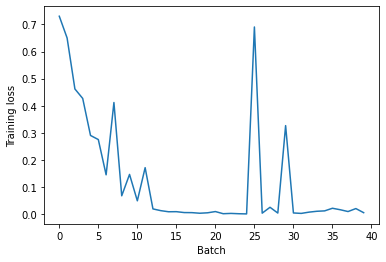

In [ ]:
#train_acc, test_acc = train_test_classification(model, loss_fn, optimizer,psded_train_loader,psded_test_loader,num_epochs=20,verbose = True,training_plot= True,device = DEVICE )

In [ ]:

# pretrained_accs = []
# for epoch in tqdm.tqdm(range(100)):
#   # Train loop
#   for batch in psded_train_loader:
#     images, labels = batch
#     images = images.to(DEVICE)
#     labels = labels.to(DEVICE)
#     optimizer.zero_grad()
#     output = model(images)
#     loss = loss_fn(output, labels)
#     print(loss.item)
#     loss.backward()
#     optimizer.step()

#   # Eval loop
#   with torch.no_grad():
#     loss_sum = 0
#     total_correct = 0
#     total = len(psded_test_set)
#     for batch in psded_test_loader:
#       images, labels = batch
#       images = images.to(DEVICE)
#       labels = labels.to(DEVICE)
#       output = model(images)
#       loss = loss_fn(output, labels)
#       loss_sum += loss.item()

#       predictions = torch.argmax(output, dim=1)

#       num_correct = torch.sum(predictions == labels)
#       total_correct += num_correct

    # Plot accuracy
  #   pretrained_accs.append(total_correct / total)
  #   plt.plot(pretrained_accs)
  #   plt.xlabel('epoch')
  #   plt.ylabel('accuracy')
  #   plt.title('Seizure prediction accuracy')
  #   IPython.display.clear_output(wait=True)
  #   IPython.display.display(plt.gcf())
  # plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

<built-in method item of Tensor object at 0x7f2810cb0c80>
<built-in method item of Tensor object at 0x7f28108ca5a0>


  1%|          | 1/100 [00:01<02:35,  1.57s/it]

<built-in method item of Tensor object at 0x7f28119d53c0>
<built-in method item of Tensor object at 0x7f28108740a0>


  2%|▏         | 2/100 [00:03<02:29,  1.52s/it]

<built-in method item of Tensor object at 0x7f281830ee10>
<built-in method item of Tensor object at 0x7f281048d9b0>


  3%|▎         | 3/100 [00:04<02:27,  1.52s/it]

<built-in method item of Tensor object at 0x7f28108a4be0>
<built-in method item of Tensor object at 0x7f281084c6e0>


  4%|▍         | 4/100 [00:06<02:24,  1.51s/it]

<built-in method item of Tensor object at 0x7f2810897c80>
<built-in method item of Tensor object at 0x7f2811529eb0>


  5%|▌         | 5/100 [00:07<02:23,  1.51s/it]

<built-in method item of Tensor object at 0x7f28108c1410>
<built-in method item of Tensor object at 0x7f2811963820>


  6%|▌         | 6/100 [00:09<02:22,  1.51s/it]

<built-in method item of Tensor object at 0x7f28108c7190>
<built-in method item of Tensor object at 0x7f281830ee60>


  7%|▋         | 7/100 [00:10<02:20,  1.51s/it]

<built-in method item of Tensor object at 0x7f2810f55a50>
<built-in method item of Tensor object at 0x7f2810bb9870>


  8%|▊         | 8/100 [00:12<02:19,  1.51s/it]

<built-in method item of Tensor object at 0x7f281121d230>
<built-in method item of Tensor object at 0x7f2810bb9a00>


  9%|▉         | 9/100 [00:13<02:18,  1.52s/it]

<built-in method item of Tensor object at 0x7f2811413550>
<built-in method item of Tensor object at 0x7f2810b85b40>


 10%|█         | 10/100 [00:15<02:17,  1.53s/it]

<built-in method item of Tensor object at 0x7f28108a4be0>
<built-in method item of Tensor object at 0x7f2811c80410>


 11%|█         | 11/100 [00:16<02:16,  1.53s/it]

<built-in method item of Tensor object at 0x7f28101a32d0>
<built-in method item of Tensor object at 0x7f28101857d0>


 12%|█▏        | 12/100 [00:18<02:15,  1.54s/it]

<built-in method item of Tensor object at 0x7f28108fcbe0>
<built-in method item of Tensor object at 0x7f2810445500>


 13%|█▎        | 13/100 [00:19<02:14,  1.55s/it]

<built-in method item of Tensor object at 0x7f2811529f50>
<built-in method item of Tensor object at 0x7f28110fa4b0>


 14%|█▍        | 14/100 [00:21<02:13,  1.55s/it]

<built-in method item of Tensor object at 0x7f28104736e0>
<built-in method item of Tensor object at 0x7f2811484d70>


 15%|█▌        | 15/100 [00:22<02:12,  1.55s/it]

<built-in method item of Tensor object at 0x7f28114940f0>
<built-in method item of Tensor object at 0x7f28119449b0>


 16%|█▌        | 16/100 [00:24<02:10,  1.56s/it]

<built-in method item of Tensor object at 0x7f2810f55eb0>
<built-in method item of Tensor object at 0x7f2810bb38c0>


 17%|█▋        | 17/100 [00:26<02:08,  1.55s/it]

<built-in method item of Tensor object at 0x7f2810f39730>


 17%|█▋        | 17/100 [00:26<02:10,  1.58s/it]


KeyboardInterrupt: ignored